# Getting familiar with CLIP

Here we test out a bunch of different CLIP and CLIP-style implementations.

## Original OpenAI CLIP
From https://github.com/openai/CLIP.

```
conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
pip install ftfy regex tqdm
pip install git+https://github.com/openai/CLIP.git
```

### Simple usage

In [3]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004185 0.002968]]


### Zero shot prediction

Copied from https://github.com/openai/CLIP: "The code below performs zero-shot prediction using CLIP, as shown in Appendix B in the paper. This example takes an image from the CIFAR-100 dataset, and predicts the most likely labels among the 100 textual labels from the dataset. Note that this example uses the `encode_image()` and `encode_text()` methods that return the encoded features of given inputs."

In [7]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

100%|██████████| 169M/169M [00:11<00:00, 15.2MB/s] 



Top predictions:

           snake: 65.53%
          turtle: 12.12%
    sweet_pepper: 3.87%
          lizard: 1.89%
       crocodile: 1.72%


### Linear-probe evaluation

Copied from https://github.com/openai/CLIP: "The example below uses scikit-learn to perform logistic regression on image features. Note that the `C` value should be determined via a hyperparameter sweep using a validation split."

In [10]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+00    |proj g|=  1.53246D-02


 This problem is unconstrained.



At iterate   50    f=  6.75614D-01    |proj g|=  8.49750D-03

At iterate  100    f=  5.84321D-01    |proj g|=  1.01679D-02

At iterate  150    f=  5.66909D-01    |proj g|=  3.72494D-03

At iterate  200    f=  5.63269D-01    |proj g|=  4.89657D-04

At iterate  250    f=  5.62606D-01    |proj g|=  2.58750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
51300    290    300      1     0     0   8.677D-05   5.625D-01
  F =  0.56246845550390634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy = 80.030


## Hugging face CLIP

From https://huggingface.co/docs/transformers/model_doc/clip.

```
pip install transformers
```

In [14]:
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open("lung_cancer.png")
text = ["female smoker", "male nonsmoker", "adenocarcinoma", "squamous cell carcinoma"]

inputs = processor(text=text, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)

logits_per_image = outputs.logits_per_image  # similarity score
probs = logits_per_image.softmax(dim=1)  # probabilities
print(probs)

tensor([[0.0009, 0.0070, 0.6385, 0.3536]], grad_fn=<SoftmaxBackward0>)


## Open source CLIP

From https://github.com/mlfoundations/open_clip.

```
pip install open_clip_torch
pip install 'open_clip_torch[training]'
```

In [16]:
import torch
from PIL import Image
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

image = preprocess(Image.open("CLIP.png")).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])

with torch.no_grad(), torch.autocast("cuda"):
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)  # prints: [[1., 0., 0.]]

Label probs: tensor([[9.9950e-01, 4.1207e-04, 8.5317e-05]])


### Interacting with open_clip

From https://github.com/mlfoundations/open_clip/blob/main/docs/Interacting_with_open_clip.ipynb.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
import open_clip
# open_clip.list_models()

In [104]:
model, _, preprocess = open_clip.create_model_and_transforms('RN50', pretrained=None)
tokenizer = open_clip.get_tokenizer('RN50')
checkpoint_path = '/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/hpl-clip/logs/HPL-RN50_train_250k_val_varied/checkpoints/epoch_16.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = {k.replace("model.", ""): v for k, v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict, strict=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device).eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Context length: 77
Vocab size: 49408


In [105]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x1554391e41f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [106]:
from open_clip import tokenizer
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

Displaying 8 sample image-caption pairs:

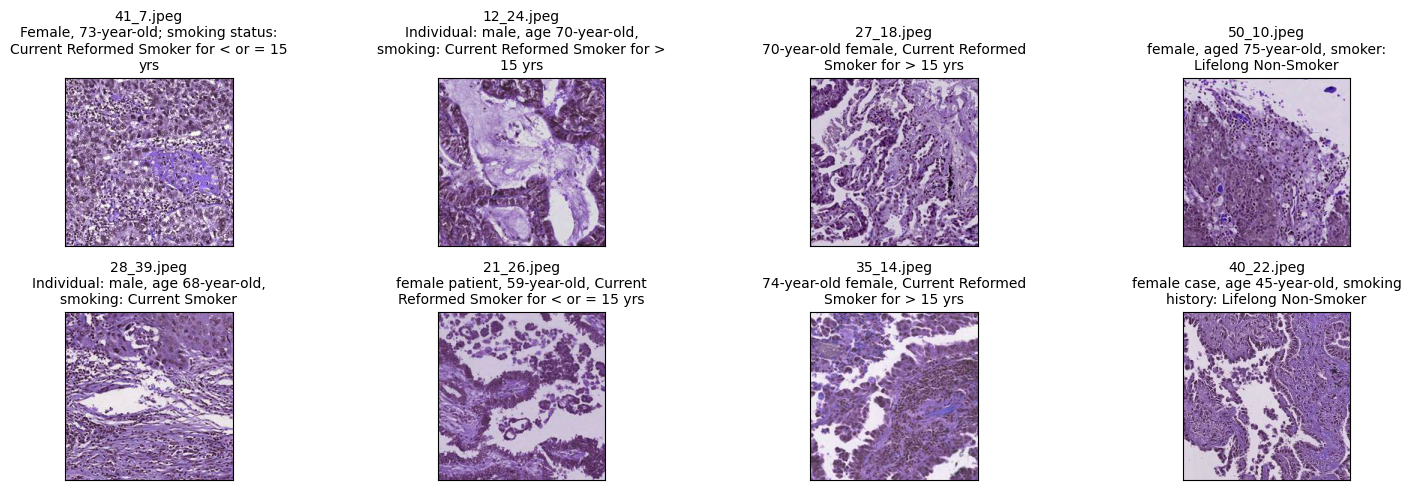

In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import textwrap

# load filepath/caption csv
csv_path = '/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/hpl-clip/short_varied_captions/lung_250k_filepath_caption.csv'
df = pd.read_csv(csv_path)

# sample 8 rows
df_sampled = df.sample(n=8, random_state=9).reset_index(drop=True)

original_images = []
images = []
texts = []

plt.figure(figsize=(16, 5))

for idx, row in df_sampled.iterrows():
    img_path = row['filepath']
    caption = row['caption']

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    image = Image.open(img_path).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=40))  # adjust width as needed
    plt.title(f"{os.path.basename(img_path)}\n{wrapped_caption}", fontsize=10)

    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(caption)

plt.tight_layout()

Showing cosine similarity between image/text embeddings:

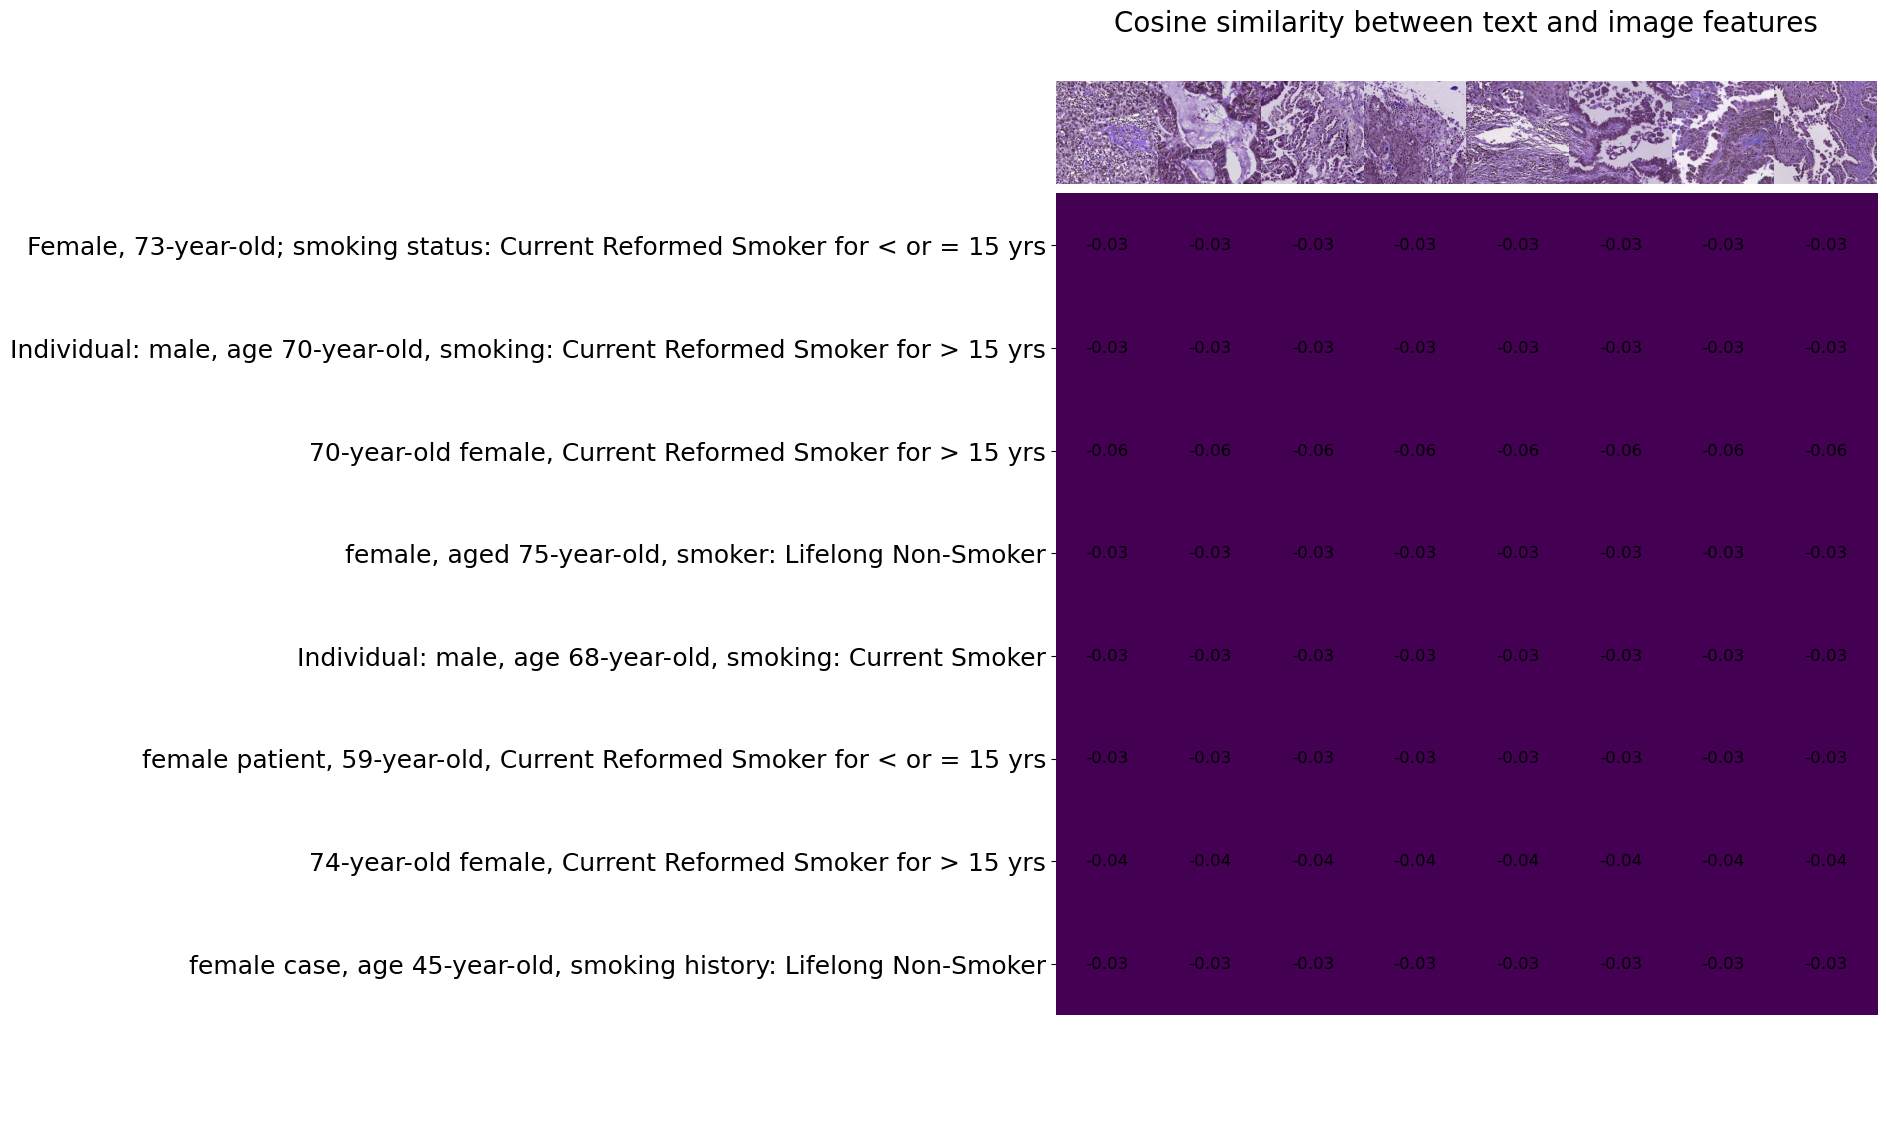

In [108]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize([desc for desc in texts])

# encode images/captions
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

plt.show()

Calculate probabilities of text prompts being paired to image:

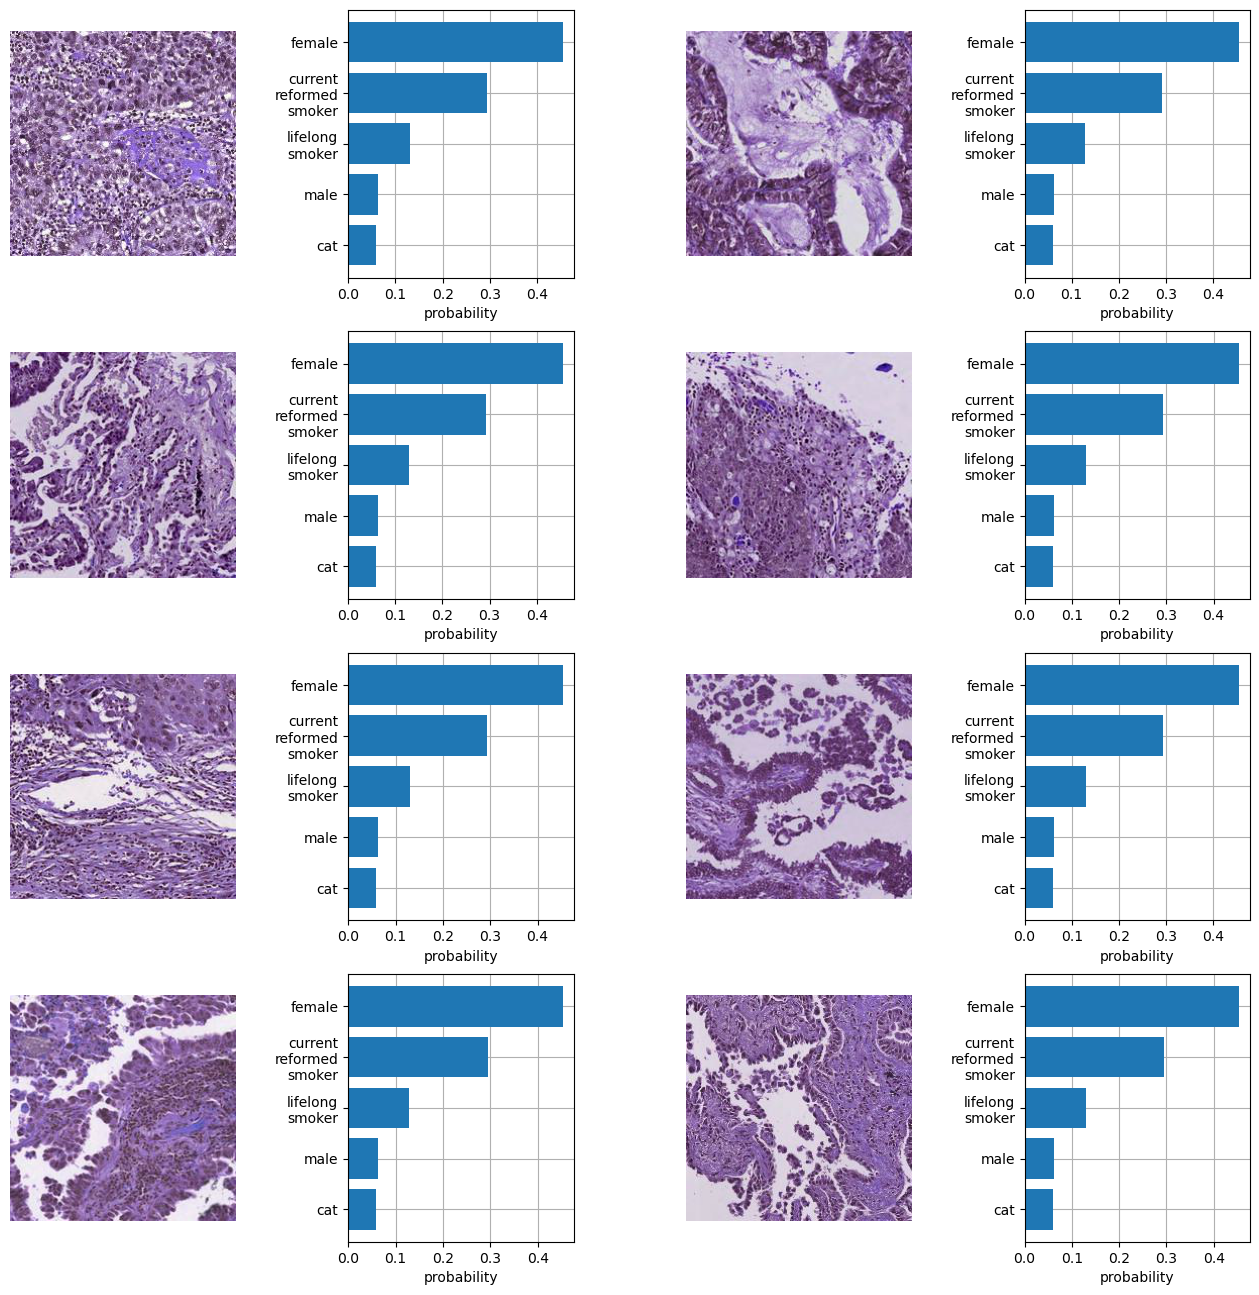

In [109]:
import textwrap

text_descriptions = ["lifelong smoker", "current reformed smoker", "female", "male", "cat"]
text_tokens = tokenizer.tokenize([desc for desc in text_descriptions])
# print(text_tokens)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(len(text_descriptions), dim=-1)

plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    wrapped_labels = [textwrap.fill(text_descriptions[index], width=12) for index in top_labels[i].numpy()]
    plt.yticks(y, wrapped_labels)
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [48]:
print("Cosine similarity between image 0 and image 1:",
      torch.nn.functional.cosine_similarity(image_features[0], image_features[1], dim=0))
print("Image features std deviation:", image_features.std(dim=0).mean())

print(image_features[0][:5])
print(image_features[1][:5])

Cosine similarity between image 0 and image 1: tensor(0.9813)
Image features std deviation: tensor(0.0053)
tensor([-0.0153, -0.0479,  0.0578,  0.1017,  0.0459])
tensor([-0.0034, -0.0444,  0.0620,  0.0928,  0.0419])


Image embeddings are collapsing!

In [110]:
print("Cosine similarity between text 0 and text 1:",
      torch.nn.functional.cosine_similarity(text_features[0], text_features[1], dim=0))
print("Text features std deviation:", text_features.std(dim=0).mean())

print(text_features[0][:5])
print(text_features[1][:5])

Cosine similarity between text 0 and text 1: tensor(0.8166)
Text features std deviation: tensor(0.0106)
tensor([-0.0279,  0.0318,  0.0193, -0.0133, -0.0063])
tensor([-0.0473,  0.0211,  0.0199, -0.0233, -0.0287])


## CONCH

From the Mahmood lab: https://github.com/mahmoodlab/CONCH.

Hugging Face: https://huggingface.co/MahmoodLab/CONCH

In [1]:
# Checkpoint downloaded to: /gpfs/home/yb2612/.cache/huggingface/hub/models--MahmoodLab--CONCH/snapshots/f9ca9f877171a28ade80228fb195ac5d79003357/pytorch_model.bin

In [11]:
from conch.open_clip_custom import create_model_from_pretrained, get_tokenizer, tokenize
model, preprocess = create_model_from_pretrained(model_cfg='conch_ViT-B-16', 
                                                 checkpoint_path='/gpfs/home/yb2612/.cache/huggingface/hub/models--MahmoodLab--CONCH/snapshots/f9ca9f877171a28ade80228fb195ac5d79003357/pytorch_model.bin')

In [12]:
import torch
_ = model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device=device)

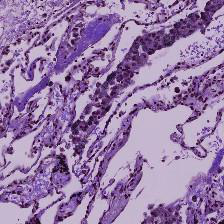

In [13]:
from PIL import Image
import torch
import matplotlib.pyplot as plt

image = Image.open('/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/train_250k/TCGA-4B-A93V-01Z-00-DX1/3_10.jpeg')
image_tensor = preprocess(image).unsqueeze(0).to(device)

# visualize thumbnail
image.resize((224, 224))

In [14]:
lung_250k_filepath_caption = pd.read_csv("/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/hpl-clip/short_varied_captions/lung_250k_filepath_caption.csv")
lung_250k_filepath_caption["caption"][lung_250k_filepath_caption["filepath"]=="/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/train_250k/TCGA-4B-A93V-01Z-00-DX1/3_10.jpeg"].values[0]

'52-year-old, female, history: Current Reformed Smoker for < or = 15 yrs'

In [15]:
tokenizer = get_tokenizer()
prompts = [
           'photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain',
           'a case of invasive lobular carcinoma as visualized using H&E stain',
           'high magnification view of a breast cancer tumor, H&E stain',
           'clear cell renal cell carcinoma',
           'lung adenocarcinoma, H&E stain',
           'IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma',
           'an image of a cat',
           'High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis',
           'metastatic tumor to the lymph node, GATA3 staining',
           'epidermis with follicular ostia',
            '52-year-old, female, history: Current Reformed Smoker for < or = 15 yrs',
        '70-year-old, male, history: lifelong non-smoker'
           ]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([12, 128])

Rank prompts based on cosine similarity:

In [16]:
with torch.inference_mode():
    image_embedings = model.encode_image(image_tensor)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (image_embedings @ text_embedings.T).squeeze(0)

print("Ranked list of prompts based on cosine similarity with the image:")
ranked_scores, ranked_idx = torch.sort(sim_scores, descending=True)
for idx, score in zip(ranked_idx, ranked_scores):
    print(f"\"{prompts[idx]}\": {score:.3f}")

Ranked list of prompts based on cosine similarity with the image:
"lung adenocarcinoma, H&E stain": 0.365
"52-year-old, female, history: Current Reformed Smoker for < or = 15 yrs": 0.298
"IHC stain for CDX2 in a case of metastatic colorectal adenocarcinoma": 0.266
"70-year-old, male, history: lifelong non-smoker": 0.256
"photomicrograph illustrating invasive ductal carcinoma of the breast, H&E stain": 0.159
"metastatic tumor to the lymph node, GATA3 staining": 0.136
"epidermis with follicular ostia": 0.077
"high magnification view of a breast cancer tumor, H&E stain": -0.001
"clear cell renal cell carcinoma": -0.028
"a case of invasive lobular carcinoma as visualized using H&E stain": -0.037
"an image of a cat": -0.083
"High-grade angiosarcoma characterized by solid areas of polygonal and spindled cells as well as necrosis": -0.118


Cosine similarity matrix:

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


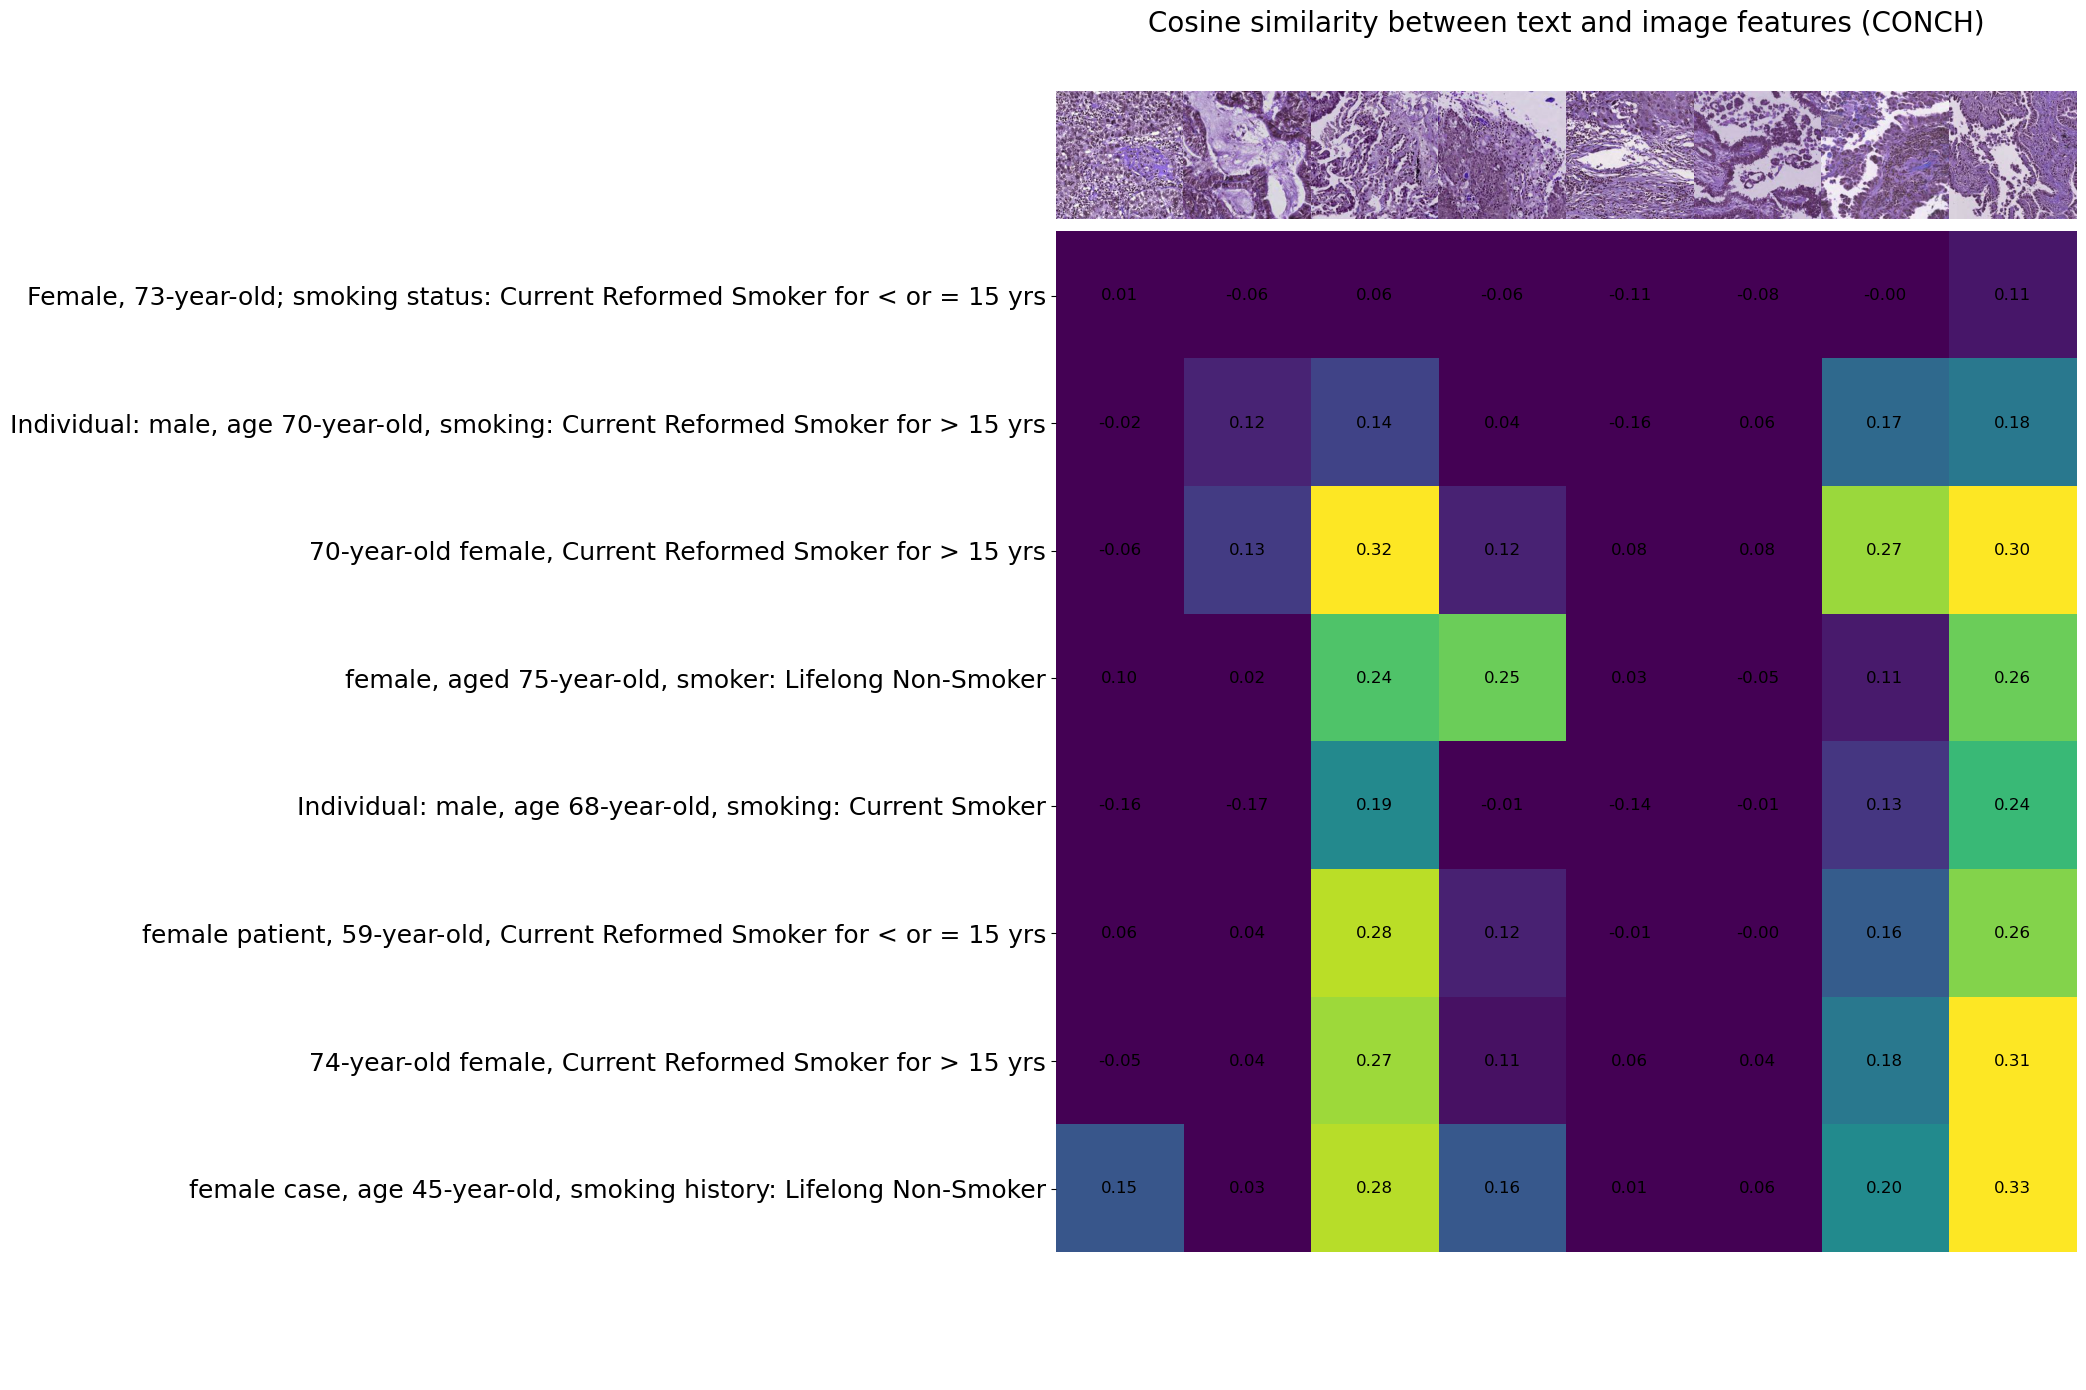

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# preprocess
images = [preprocess(img) for img in original_images]
image_input = torch.stack(images).to(device)

# tokenize
text_tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

# encode image/text
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens['input_ids']).float()  # Use 'input_ids' from tokenized output

# normalize
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# cosine similarity matrix
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
count = len(texts)

# heatmap
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3, cmap='viridis')

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

for i, image in enumerate(original_images):
    thumb = image.resize((224, 224))  # Resize for consistency
    plt.imshow(thumb, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])
plt.title("Cosine similarity between text and image features (CONCH)", size=20)
plt.tight_layout()
plt.show()
